# TP - Computação Natural
#### "Predict whether a mammogram mass is benign or malignant"

1. BI-RADS assessment: 1 to 5 (ordinal)  
2. Age: patient's age in years (integer)
3. Shape: mass shape: round=1 oval=2 lobular=3 irregular=4 (nominal)
4. Margin: mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5 (nominal)
5. Density: mass density high=1 iso=2 low=3 fat-containing=4 (ordinal)
6. Severity: benign=0 or malignant=1 (binominal)

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from scipy import stats
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, RMSprop, Adam

Using TensorFlow backend.


## Get the Data

In [2]:
data = pd.read_csv('mammographic_masses.data.txt', names=['BI_RADS','Age','Shape','Margin','Density','Severity'])

Convert missing data (indicated by a ?) into NaN and add the appropriate column names (BI_RADS, age, shape, margin, density, and severity)

In [3]:
data = data.replace('?',np.nan)
data

,BI_RADS,Age,Shape,Margin,Density,Severity
0,5,67,3,5,3,1
1,4,43,1,1,NaN,1
2,5,58,4,5,3,1
3,4,28,1,1,3,0
4,5,74,1,5,NaN,1
...,...,...,...,...,...,...
956,4,47,2,1,3,0
957,4,56,4,5,3,1
958,4,64,4,5,3,0
959,5,66,4,5,3,1


**Drop BI_RADS column because it has no influence on the severity forecast**

In [4]:
data = data.drop(columns=['BI_RADS'])

**Convert datatype 'object' to 'float64'**  

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 5 columns):
Age         956 non-null object
Shape       930 non-null object
Margin      913 non-null object
Density     885 non-null object
Severity    961 non-null int64
dtypes: int64(1), object(4)
memory usage: 37.7+ KB


In [6]:
data = data.astype(float)
data

,Age,Shape,Margin,Density,Severity
0,67.0,3.0,5.0,3.0,1.0
1,43.0,1.0,1.0,NaN,1.0
2,58.0,4.0,5.0,3.0,1.0
3,28.0,1.0,1.0,3.0,0.0
4,74.0,1.0,5.0,NaN,1.0
...,...,...,...,...,...
956,47.0,2.0,1.0,3.0,0.0
957,56.0,4.0,5.0,3.0,1.0
958,64.0,4.0,5.0,3.0,0.0
959,66.0,4.0,5.0,3.0,1.0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 5 columns):
Age         956 non-null float64
Shape       930 non-null float64
Margin      913 non-null float64
Density     885 non-null float64
Severity    961 non-null float64
dtypes: float64(5)
memory usage: 37.7 KB


In [8]:
data.describe()

,Age,Shape,Margin,Density,Severity
count,956.000000,930.000000,913.000000,885.000000,961.000000
mean,55.487448,2.721505,2.796276,2.910734,0.463059
std,14.480131,1.242792,1.566546,0.380444,0.498893
min,18.000000,1.000000,1.000000,1.000000,0.000000
25%,45.000000,2.000000,1.000000,3.000000,0.000000
50%,57.000000,3.000000,3.000000,3.000000,0.000000
75%,66.000000,4.000000,4.000000,3.000000,1.000000
max,96.000000,4.000000,5.000000,4.000000,1.000000


### Analysing missing values
**First we get the missing values per feature.**

*Lets check them out as well*

In [9]:
missing_values_feature = data.isnull().sum(axis=0)
graph = missing_values_feature.drop(labels='Severity')
graph

Age         5
Shape      31
Margin     48
Density    76
dtype: int64

<BarContainer object of 4 artists>

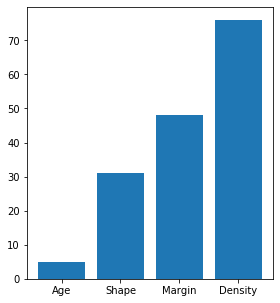

In [10]:
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.bar(graph.axes[0].to_list(), graph.values)

*We then develop a heatmap to give us some more information*

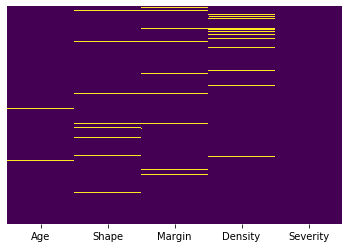

In [11]:
sns.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

*Finally we can check the percentage of missing values per feature*

In [12]:
percent_missing = data.isnull().sum() * 100 / len(data)
missing_value_df = pd.DataFrame({'percent_missing': percent_missing})
print(missing_value_df)

          percent_missing
Age              0.520291
Shape            3.225806
Margin           4.994797
Density          7.908429
Severity         0.000000


**After analysing the columns, we should have a look at the rows**

In [13]:
data_missing = len(data.columns) - (data.apply(lambda x: x.count(), axis=1))
missing_values_data_rows = pd.DataFrame({'data_missing':data_missing})
missing_values_data_rows.sort_values('data_missing',inplace=True,ascending=False)
missing_values_data_rows

,data_missing
100,2
87,2
35,2
752,2
48,2
...,...
373,0
374,0
376,0
377,0


**Now lets analyse the missing data per class (Severity = 0 or Severity = 1).**

*First we group the missing values per class*

In [14]:
grouped_data = data.groupby('Severity')
missing_values_class = grouped_data.count().rsub(grouped_data.size(), axis=0)
missing_values_class

,Age,Shape,Margin,Density
Severity,,,,
0.0,0,19,37,54
1.0,5,12,11,22


*Now we split the dataframe per class so we can draw our plot*

In [15]:
m_new_1, m_new_2 = missing_values_class.head(1), missing_values_class.tail(1)

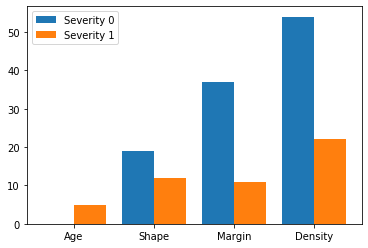

In [16]:
x = np.arange(len(m_new_1.axes[1].to_list()))
width = 0.4

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, m_new_1.values[0], width=width, label = "Severity 0")
rects2 = ax.bar(x + width/2, m_new_2.values[0], width=width, label = "Severity 1")

ax.set_xticks(x)
ax.set_xticklabels(m_new_1.axes[1].to_list())
ax.legend()

**Finally, for each class we're going to calculate the number of rows that have 1 and 2 NaN values**

In [17]:
rows_mv1_sv0 = 0
rows_mv2_sv0 = 0
rows_mv1_sv1 = 0
rows_mv2_sv1 = 0

In [18]:
for index, row in data.iterrows():
    if(row['Severity'] == 0):
        if(row.isnull().sum() == 1):
            rows_mv1_sv0 += 1
        elif(row.isnull().sum() == 2):
            rows_mv2_sv0 += 1
    else:
        if(row.isnull().sum() == 1):
            rows_mv1_sv1 += 1
        elif(row.isnull().sum() == 2):
            rows_mv2_sv1 += 1

*We create a dataframe only for visualization purpose*

In [19]:
numberofnan_class = pd.DataFrame(np.array([[rows_mv1_sv0,rows_mv2_sv0], [rows_mv1_sv1,rows_mv2_sv1]]), 
                                    index=['Severity 0','Severity 1'], columns=['1 NaN', '2 NaN'])
numberofnan_class

,1 NaN,2 NaN
Severity 0,66,22
Severity 1,34,8


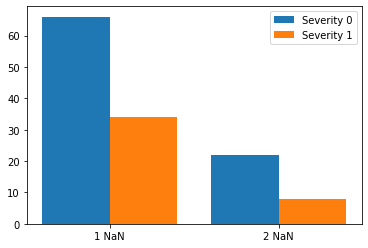

In [20]:
labels = ['1 NaN', '2 NaN']
x = np.arange(len(labels))
width = 0.4

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, [rows_mv1_sv0,rows_mv2_sv0], width=width, label = "Severity 0")
rects2 = ax.bar(x + width/2, [rows_mv1_sv1,rows_mv2_sv1], width=width, label = "Severity 1")

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

*With this information we can also see the number of rows with 1 or 2 missing values per class*

In [21]:
nan_class = pd.DataFrame(np.array([[rows_mv1_sv0+rows_mv2_sv0], [rows_mv1_sv1+rows_mv2_sv1]]), 
                                    index=['Severity 0','Severity 1'], columns=['Sum'])
nan_class

,Sum
Severity 0,88
Severity 1,42


<BarContainer object of 2 artists>

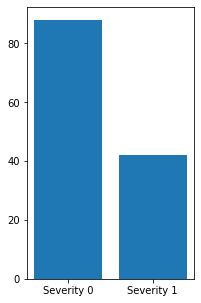

In [22]:
plt.figure(figsize=(3, 5))
plt.bar(['Severity 0','Severity 1'],[rows_mv1_sv0+rows_mv2_sv0,rows_mv1_sv1+rows_mv2_sv1])

**The missing data seems randomly distributed, so we decided to go with the following strategy:**

* Drop rows with 2 NaN values

* Replace the NaN values from rows with 1 missing value

*First we get the mode of every feature for each class*

In [23]:
mode_sv0 = data[data['Severity'] == 0].mode()
mode_sv1 = data[data['Severity'] == 1].mode()
mode_sv0 = mode_sv0.drop([1])
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(mode_sv0)
    print(mode_sv1)

    Age  Shape  Margin  Density  Severity
0  46.0    1.0     1.0      3.0       0.0
    Age  Shape  Margin  Density  Severity
0  67.0    4.0     4.0      3.0       1.0


*After we create conditions to replace the NaN values on rows with 1 missing value.*

*For that we need the index of the rows which have 1 missing value.*

In [24]:
rows_1nan = missing_values_data_rows.index[missing_values_data_rows['data_missing'] == 1].tolist()
mask_sv0 = (data['Severity'] == 0) & (data.index.isin(rows_1nan))
mask_sv1 = (data['Severity'] == 1) & (data.index.isin(rows_1nan))

*We can now proceed and replace the missing values for their class mode* 

In [25]:
data.loc[mask_sv0, 'Shape'] = data.loc[mask_sv0, 'Shape'].fillna(mode_sv0.loc[0,'Shape'])
data.loc[mask_sv0, 'Margin'] = data.loc[mask_sv0, 'Margin'].fillna(mode_sv0.loc[0,'Margin'])
data.loc[mask_sv0, 'Density'] = data.loc[mask_sv0, 'Density'].fillna(mode_sv0.loc[0,'Density'])
data.loc[mask_sv1, 'Age'] = data.loc[mask_sv1, 'Age'].fillna(mode_sv1.loc[0,'Age'])
data.loc[mask_sv1, 'Shape'] = data.loc[mask_sv1, 'Shape'].fillna(mode_sv1.loc[0,'Shape'])
data.loc[mask_sv1, 'Margin'] = data.loc[mask_sv1, 'Margin'].fillna(mode_sv1.loc[0,'Margin'])
data.loc[mask_sv1, 'Density'] = data.loc[mask_sv1, 'Density'].fillna(mode_sv1.loc[0,'Density'])
data

,Age,Shape,Margin,Density,Severity
0,67.0,3.0,5.0,3.0,1.0
1,43.0,1.0,1.0,3.0,1.0
2,58.0,4.0,5.0,3.0,1.0
3,28.0,1.0,1.0,3.0,0.0
4,74.0,1.0,5.0,3.0,1.0
...,...,...,...,...,...
956,47.0,2.0,1.0,3.0,0.0
957,56.0,4.0,5.0,3.0,1.0
958,64.0,4.0,5.0,3.0,0.0
959,66.0,4.0,5.0,3.0,1.0


*Finally, we can drop rows with NaN values because the only ones that are left are the ones with 2 NaN*

In [26]:
data = data.dropna()
data.index = np.arange(1, len(data) + 1)
data

,Age,Shape,Margin,Density,Severity
1,67.0,3.0,5.0,3.0,1.0
2,43.0,1.0,1.0,3.0,1.0
3,58.0,4.0,5.0,3.0,1.0
4,28.0,1.0,1.0,3.0,0.0
5,74.0,1.0,5.0,3.0,1.0
...,...,...,...,...,...
927,47.0,2.0,1.0,3.0,0.0
928,56.0,4.0,5.0,3.0,1.0
929,64.0,4.0,5.0,3.0,0.0
930,66.0,4.0,5.0,3.0,1.0


## Exploratory Data Analysis

**Auxiliar functions & General definitions**

In [27]:
c_palette = ['tab:green','tab:red']

def categorical_summarized(dataframe, x=None, y=None, hue=None, palette='Set1', verbose=True):
    if x == None:
        column_interested = y
    else:
        column_interested = x
    series = dataframe[column_interested]
    print(series.describe())
    print('mode: ', series.mode())
    if verbose:
        print('='*80)
        print(series.value_counts())

    sns.countplot(x=x, y=y, hue=hue, data=dataframe, palette=palette)
    plt.show()

def quantitative_summarized(dataframe, x=None, y=None, hue=None, palette='Set1', ax=None, verbose=True, swarm=False):
    series = dataframe[y]
    print(series.describe())
    print('mode: ', series.mode())
    if verbose:
        print('='*80)
        print(series.value_counts())

    sns.boxplot(x=x, y=y, hue=hue, data=dataframe, palette=palette, ax=ax)

    if swarm:
        sns.swarmplot(x=x, y=y, hue=hue, data=dataframe,
                      palette=palette, ax=ax)

    plt.show()

**Countplot of the Severity (Benign 0 vs Malignant 1)**

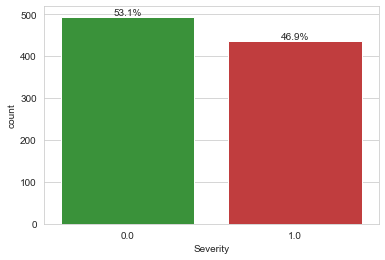

In [28]:
sns.set_style('whitegrid')
ax = sns.countplot(x='Severity',data=data,palette=c_palette)


total = len(data['Severity'])

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:.1f}%'.format(100 * height/total),
            ha="center") 

**Severity on Age**

count    931.000000
mean      55.654135
std       14.524086
min       18.000000
25%       45.000000
50%       57.000000
75%       66.000000
max       96.000000
Name: Age, dtype: float64
mode:  0    67.0
dtype: float64


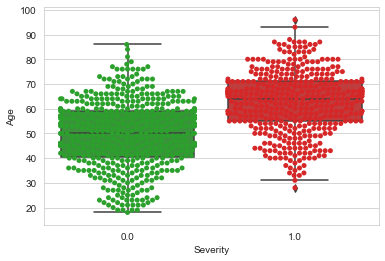

In [29]:
quantitative_summarized(dataframe= data, y = 'Age', x = 'Severity', palette=c_palette, verbose=False, swarm=True)

/usr/local/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


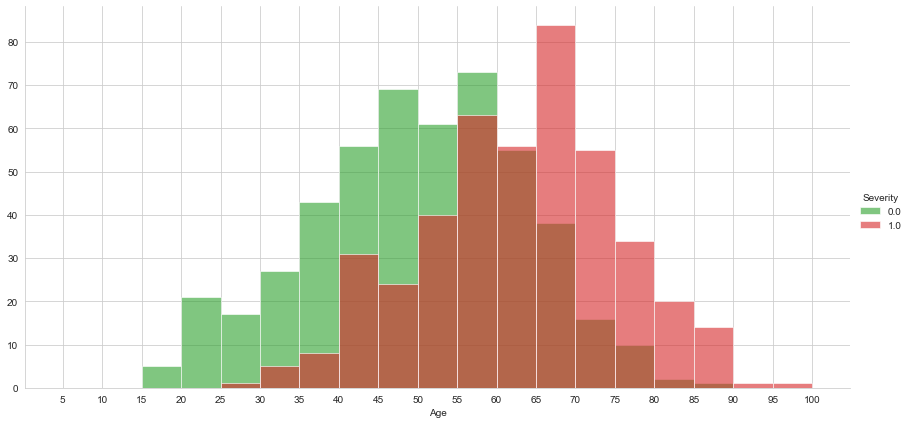

In [30]:
g = sns.FacetGrid(data,hue='Severity',palette=c_palette,size=6,aspect=2)
bins=[5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]
g.map(plt.hist, "Age", bins=bins, alpha=0.6).add_legend()
plt.xticks([5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100])
plt.show()

**Severity on Shape (mass shape: round=1 oval=2 lobular=3 irregular=4)**

count    931.000000
mean       2.728249
std        1.248762
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        4.000000
Name: Shape, dtype: float64
mode:  0    4.0
dtype: float64
4.0    406
1.0    227
2.0    205
3.0     93
Name: Shape, dtype: int64


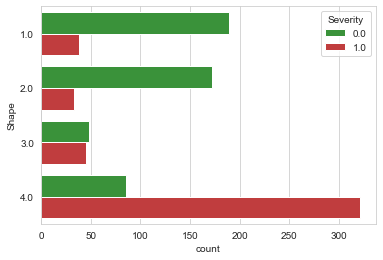

In [31]:
categorical_summarized(data, y = 'Shape', hue='Severity', palette=c_palette)

**Severity on Margin (mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5)**

count    931.000000
mean       2.766917
std        1.568652
min        1.000000
25%        1.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: Margin, dtype: float64
mode:  0    1.0
dtype: float64
1.0    373
4.0    283
5.0    135
3.0    116
2.0     24
Name: Margin, dtype: int64


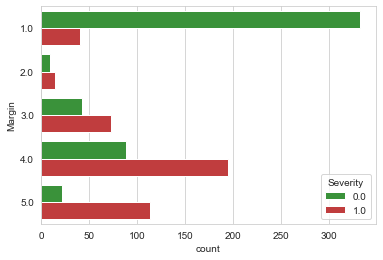

In [32]:
categorical_summarized(data, y = 'Margin', hue='Severity', palette=c_palette)

**Severity on Density (mass density high=1 iso=2 low=3 fat-containing=4)**

count    931.000000
mean       2.915145
std        0.362631
min        1.000000
25%        3.000000
50%        3.000000
75%        3.000000
max        4.000000
Name: Density, dtype: float64
mode:  0    3.0
dtype: float64
3.0    847
2.0     59
1.0     15
4.0     10
Name: Density, dtype: int64


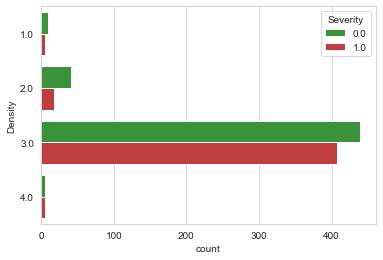

In [33]:
categorical_summarized(data, y = 'Density', hue='Severity', palette=c_palette)

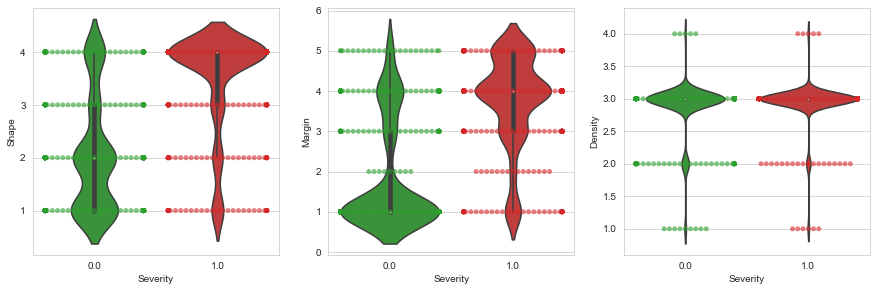

In [34]:
fig = plt.figure(figsize = (15,10))

ax1 = fig.add_subplot(2,3,1)
sns.violinplot(data = data, x='Severity', y='Shape', palette=c_palette, ax=ax1)
sns.swarmplot(data = data, x='Severity', y='Shape', color = 'k', alpha = 0.6, palette=c_palette, ax=ax1)

ax2 = fig.add_subplot(2,3,2)
sns.violinplot(data = data, x='Severity', y='Margin', palette=c_palette, ax=ax2)
sns.swarmplot(data = data, x='Severity', y='Margin', color = 'k', alpha = 0.6, palette=c_palette, ax=ax2)

ax3 = fig.add_subplot(2,3,3)
sns.violinplot(data = data, x='Severity', y='Density', palette=c_palette, ax=ax3)
sns.swarmplot(data = data, x='Severity', y='Density', color = 'k', alpha = 0.6, palette=c_palette, ax=ax3)

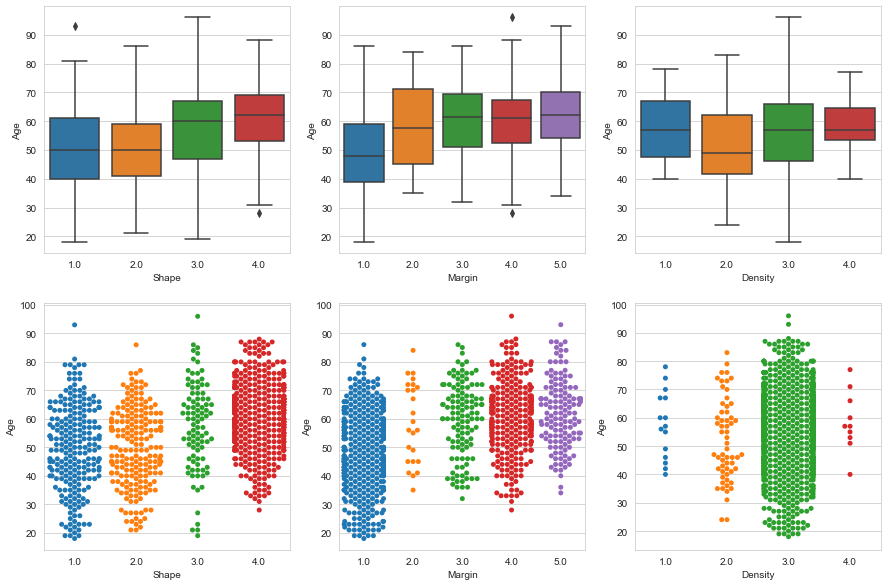

In [35]:
fig = plt.figure(figsize = (15,10))

ax1 = fig.add_subplot(2,3,1)
sns.boxplot(data = data, x='Shape', y='Age', ax=ax1)

ax2 = fig.add_subplot(2,3,2)
sns.boxplot(data = data, x='Margin', y='Age', ax=ax2)

ax3 = fig.add_subplot(2,3,3)
sns.boxplot(data = data, x='Density', y='Age', ax=ax3)

ax4 = fig.add_subplot(2,3,4)
sns.swarmplot(data = data, x='Shape', y='Age', ax=ax4)

ax5 = fig.add_subplot(2,3,5)
sns.swarmplot(data = data, x='Margin', y='Age', ax=ax5)

ax6 = fig.add_subplot(2,3,6)
sns.swarmplot(data = data, x='Density', y='Age', ax=ax6)

count    931.000000
mean       2.766917
std        1.568652
min        1.000000
25%        1.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: Margin, dtype: float64
mode:  0    1.0
dtype: float64
1.0    373
4.0    283
5.0    135
3.0    116
2.0     24
Name: Margin, dtype: int64


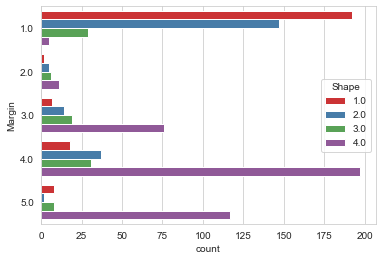

In [36]:
categorical_summarized(data, y = 'Margin', hue='Shape')

count    931.000000
mean       2.915145
std        0.362631
min        1.000000
25%        3.000000
50%        3.000000
75%        3.000000
max        4.000000
Name: Density, dtype: float64
mode:  0    3.0
dtype: float64
3.0    847
2.0     59
1.0     15
4.0     10
Name: Density, dtype: int64


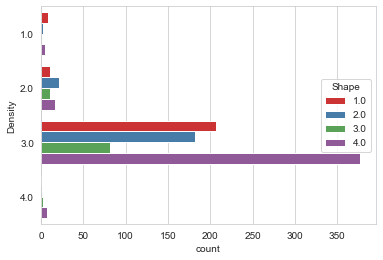

In [37]:
categorical_summarized(data, y = 'Density', hue='Shape')

count    931.000000
mean       2.915145
std        0.362631
min        1.000000
25%        3.000000
50%        3.000000
75%        3.000000
max        4.000000
Name: Density, dtype: float64
mode:  0    3.0
dtype: float64
3.0    847
2.0     59
1.0     15
4.0     10
Name: Density, dtype: int64


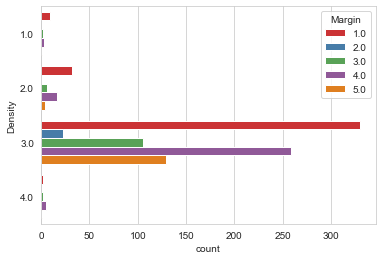

In [38]:
categorical_summarized(data, y = 'Density', hue='Margin')

In [39]:
#sns.set_style('whitegrid')
#sns.pairplot(data, hue = 'Severity', size = 4, palette=c_palette)
#plt.show()

##### Detect outliers: https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba

### Detect Outliers using Box plot (Uni-variate outlier)

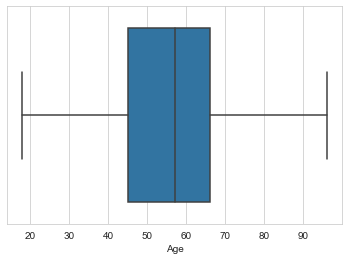

In [40]:
sns.boxplot(x=data['Age'])

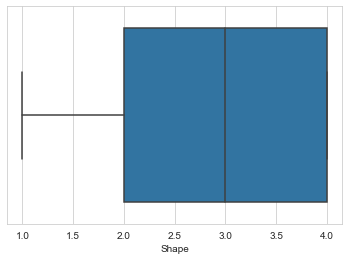

In [41]:
sns.boxplot(x=data['Shape'])

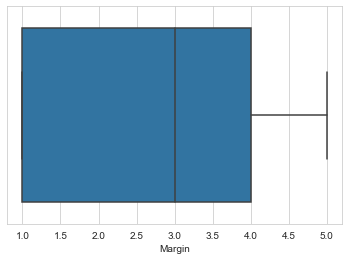

In [42]:
sns.boxplot(x=data['Margin'])

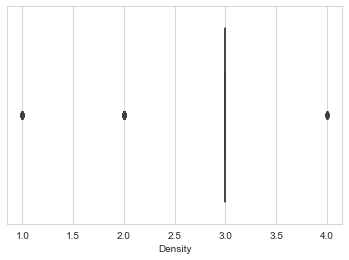

In [43]:
sns.boxplot(x=data['Density'])

### Detect Outliers using Scatter plot (Multi-variate outlier)

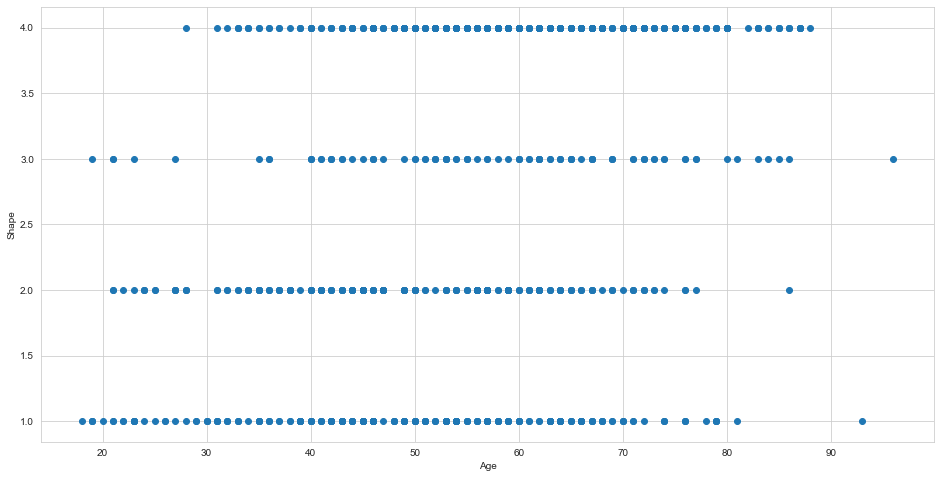

In [44]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(data['Age'], data['Shape'])
ax.set_xlabel('Age')
ax.set_ylabel('Shape')
#ax.set_ylabel('Margin')
#ax.set_ylabel('Density')
plt.show()

### Detect outliers using mathematical function Z-Score

In [45]:
z = np.abs(stats.zscore(data))
threshold = 3
print(np.where(z > threshold))
# The first array contains the list of row numbers and second array respective column numbers

(array([  8,  18,  36,  50,  71,  75, 192, 209, 218, 240, 600, 656, 793,
       861, 913]), array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]))


Column 3 (density) has all outliers

### Detect outliers using IQR Score
Similar to Z-Score

In [46]:
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
iqr = Q3 - Q1
print(iqr)

Age         21.0
Shape        2.0
Margin       3.0
Density      0.0
Severity     1.0
dtype: float64


## Data Preparation

### Remove Outliers using Z-Score

##### + explanations: https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame

In [47]:
# Como z-score estava
#data = data[(np.abs(stats.zscore(data)) < 3).all(axis=1)]
#data.index = np.arange(1, len(data) + 1)
#data

**StandardScaler to Age and One Hot Encode to other features**

In [48]:
col_names = ['Age']
features = data[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
data[col_names] = features

one_hot = pd.get_dummies(data['Shape'])
data = data.drop('Shape',axis = 1)
data = data.join(one_hot)
data = data.rename(columns={1.0: "Shape_1", 2.0: "Shape_2", 3.0: "Shape_3", 4.0: "Shape_4"})

one_hot = pd.get_dummies(data['Margin'])
data = data.drop('Margin',axis = 1)
data = data.join(one_hot)
data = data.rename(columns={1.0: "Margin_1", 2.0: "Margin_2", 3.0: "Margin_3", 4.0: "Margin_4", 5.0: "Margin_5"})

one_hot = pd.get_dummies(data['Density'])
data = data.drop('Density',axis = 1)
data = data.join(one_hot)
data = data.rename(columns={1.0: "Density_1", 2.0: "Density_2", 3.0: "Density_3", 4.0: "Density_4"})


data

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:3498: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:3469: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

,Age,Severity,Shape_1,Shape_2,Shape_3,Shape_4,Margin_1,Margin_2,Margin_3,Margin_4,Margin_5,Density_1,Density_2,Density_3,Density_4
1,0.781596,1.0,0,0,1,0,0,0,0,0,1,0,0,1,0
2,-0.871720,1.0,1,0,0,0,1,0,0,0,0,0,0,1,0
3,0.161602,1.0,0,0,0,1,0,0,0,0,1,0,0,1,0
4,-1.905042,0.0,1,0,0,0,1,0,0,0,0,0,0,1,0
5,1.263813,1.0,1,0,0,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
927,-0.596167,0.0,0,1,0,0,1,0,0,0,0,0,0,1,0
928,0.023826,1.0,0,0,0,1,0,0,0,0,1,0,0,1,0
929,0.574931,0.0,0,0,0,1,0,0,0,0,1,0,0,1,0
930,0.712708,1.0,0,0,0,1,0,0,0,0,1,0,0,1,0


## Train Test Split

**Create training and testing sets of the data**

In [49]:
X = data.drop('Severity',axis=1).to_numpy()
y = data['Severity'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
data

,Age,Severity,Shape_1,Shape_2,Shape_3,Shape_4,Margin_1,Margin_2,Margin_3,Margin_4,Margin_5,Density_1,Density_2,Density_3,Density_4
1,0.781596,1.0,0,0,1,0,0,0,0,0,1,0,0,1,0
2,-0.871720,1.0,1,0,0,0,1,0,0,0,0,0,0,1,0
3,0.161602,1.0,0,0,0,1,0,0,0,0,1,0,0,1,0
4,-1.905042,0.0,1,0,0,0,1,0,0,0,0,0,0,1,0
5,1.263813,1.0,1,0,0,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
927,-0.596167,0.0,0,1,0,0,1,0,0,0,0,0,0,1,0
928,0.023826,1.0,0,0,0,1,0,0,0,0,1,0,0,1,0
929,0.574931,0.0,0,0,0,1,0,0,0,0,1,0,0,1,0
930,0.712708,1.0,0,0,0,1,0,0,0,0,1,0,0,1,0


In [50]:
np.info(X_train)
print("---")
np.info(X_test)
print("---")
np.info(y_train)
print("---")
np.info(y_test)

class:  ndarray
shape:  (651, 14)
strides:  (112, 8)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x13ca8e000
byteorder:  little
byteswap:  False
type: float64
---
class:  ndarray
shape:  (280, 14)
strides:  (112, 8)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x7feb148c4600
byteorder:  little
byteswap:  False
type: float64
---
class:  ndarray
shape:  (651,)
strides:  (8,)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  True
data pointer: 0x7feb148cc200
byteorder:  little
byteswap:  False
type: float64
---
class:  ndarray
shape:  (280,)
strides:  (8,)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  True
data pointer: 0x7feb148cd800
byteorder:  little
byteswap:  False
type: float64


## Neural Networks & Genetic Algorithms

In [60]:
# Função que contrói o modelo ANN
def buildModel(hidden_layers, nodes_per_layer, activation_fn, optimizer, lr, loss_fn, metrics, inputs=14):
    model = Sequential()
    #add input layer
    model.add(Dense(inputs, activation="sigmoid", input_shape=(inputs,)))

    #add hidden layers    
    for i in range(int(hidden_layers)):
        model.add(Dense(int(nodes_per_layer), activation=activation_fn))

    #add output layer
    model.add(Dense(1,activation="sigmoid"))
    
    if(optimizer=='SGD'): optimizer = SGD(learning_rate=lr)
    elif(optimizer=='RMSprop'): optimizer = RMSprop(learning_rate=lr)
    elif(optimizer=='Adam'): optimizer = Adam(learning_rate=lr)

    #compile model
    model.compile(optimizer, loss=loss_fn, metrics=metrics)

    return model

# Função que realiza uma previsão para o modelo
def evaluatePredictions(model, input_attributes, labels):
    predicted = model.predict(input_attributes)
    

    # arredondar para 0 ou 1 pois pretende-se um output binário
    LP = []
    f = lambda x: int(round(x))
    vfunc = np.vectorize(f)
    
    for prev in predicted:
        prev = vfunc(prev)
        LP.append(prev)
    
    accuracy = accuracy_score(labels, LP)
    recall = recall_score(labels, LP, average=None)
    precision = precision_score(labels, LP, average=None)
    
    return accuracy, recall[0], precision[0], recall[1], precision[1]

    
#Função que cria a população inicial
#parameters=[hidden_layers,nodes_per_layer,activation_fn,learning_rate,optimizer,loss_fn]
def create_new_population():
    
    population=[]
    
    for i in range(10):
        cromo=[]
        cromo.append(np.random.randint(low=1, high=17))
        cromo.append(np.random.choice([1, 2, 4, 8, 16, 32, 64, 128, 256]))
        cromo.append(np.random.randint(low=0, high=6))
        cromo.append(np.random.choice([0.001, 0.01, 0.1, 1]))
        cromo.append(np.random.randint(low=0, high=3))
        cromo.append(np.random.randint(low=0, high=3))
        population.append(cromo)
        
    return np.array(population)

#Função genérica que atualiza os argumentos do classifier
#parameters=[hidden_layers,nodes_per_layer,activation_fn,learning_rate,optimizer,loss_fn]
def update_model_parameters(parameters):
    
    if((parameters[2]) == 0): a_f = 'relu'
    if((parameters[2]) == 1): a_f = 'selu'
    if((parameters[2]) == 2): a_f = 'sigmoid'
    if((parameters[2]) == 3): a_f = 'tanh'
    if((parameters[2]) == 4): a_f = 'linear'
    if((parameters[2]) == 5): a_f = 'softmax'
        
        
    if((parameters[4]) == 0): opt_f = 'SGD'
    if((parameters[4]) == 1): opt_f = 'RMSprop'
    if((parameters[4]) == 2): opt_f = 'Adam'
        
    if((parameters[5]) == 0): loss = 'binary_crossentropy'
    if((parameters[5]) == 1): loss = 'hinge'
    if((parameters[5]) == 2): loss = 'squared_hinge'
        
    model = buildModel(parameters[0], parameters[1], a_f, opt_f, parameters[3], loss, metrics=['accuracy'])

    return model

def select_mating_pool(pop, fitness, parents_fitness, num_parents):
    # Selecting the best individuals in the current generation as parents for producing the offspring of the next generation.
    parents = np.empty((num_parents, pop.shape[1]))
    parents_fitness = []
    for parent_num in range(num_parents):
        #save fitness values of best parents
        parents_fitness.append(np.max(fitness))
        #save best parents
        max_fitness_idx = np.where(fitness == np.max(fitness))
        max_fitness_idx = max_fitness_idx[0][0]
        parents[parent_num, :] = pop[max_fitness_idx, :]
        fitness[max_fitness_idx] = -99999999999
        
    return parents, parents_fitness

def crossover(parents, offspring_size):
    offspring = np.empty(offspring_size)
    # The point at which crossover takes place between two parents. Usually it is at the center.
    crossover_point = np.uint8(offspring_size[1]/2)

    for k in range(offspring_size[0]):
        # Index of the first parent to mate.
        parent1_idx = k%parents.shape[0]
        # Index of the second parent to mate.
        parent2_idx = (k+1)%parents.shape[0]
        # The new offspring will have its first half of its genes taken from the first parent.
        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        # The new offspring will have its second half of its genes taken from the second parent.
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
    return offspring

def mutation(offspring_crossover):
    # Mutation changes a single gene in each offspring randomly.
    for idx in range(offspring_crossover.shape[0]):
        
        # Select which gene to mutate
        select_gene = np.random.randint(low=0, high=6)
 
        if(select_gene == 0):
            #num_hidden_layers mutation
            random_value = np.random.randint(low=1, high=17)
            offspring_crossover[idx,0] = random_value
        if(select_gene == 1):
            #num_nodes_per_layer mutation
            random_value = np.random.choice([4, 8, 16, 32, 64, 128, 256])
            offspring_crossover[idx,1] = random_value
        if(select_gene == 2):
            #activation function mutation
            random_value = np.random.randint(low=0, high=6)
            offspring_crossover[idx,2] = random_value
        if(select_gene == 3):
            #learning rate mutation
            random_value = np.random.choice([0.001, 0.01, 0.1, 1])
            offspring_crossover[idx,3] = random_value
        if(select_gene == 4):
            #optimizer mutation
            random_value = np.random.randint(low=0, high=3)
            offspring_crossover[idx,4] = random_value
        if(select_gene == 5):
            #loss function mutation
            random_value = np.random.randint(low=0, high=3)
            offspring_crossover[idx,5] = random_value
            
    return offspring_crossover

def printChromo(chromo, tab=False):
    
    identation = "\t" if tab else ""
    
    if((chromo[2]) == 0): a_f = 'relu'
    if((chromo[2]) == 1): a_f = 'selu'
    if((chromo[2]) == 2): a_f = 'sigmoid'
    if((chromo[2]) == 3): a_f = 'tanh'
    if((chromo[2]) == 4): a_f = 'linear'
    if((chromo[2]) == 5): a_f = 'softmax'
        
        
    if((chromo[4]) == 0): opt_f = 'SGD'
    if((chromo[4]) == 1): opt_f = 'RMSprop'
    if((chromo[4]) == 2): opt_f = 'Adam'
        
    if((chromo[5]) == 0): loss = 'binary_crossentropy'
    if((chromo[5]) == 1): loss = 'hinge'
    if((chromo[5]) == 2): loss = 'squared_hinge'
        
    print(identation + "Layers: {} |".format(int(chromo[0])),"Nodes: {} |".format(chromo[1]),"Act_F: {} |".format(a_f),"Opti: {} |".format(opt_f), "LR: {} |".format(chromo[3]),"Loss: {}".format(loss))
    
def printChromos(chromos, tab=False):
    for chromo in chromos:
        printChromo(chromo, tab)
    
    

**K-Fold Cross Validation**

In [52]:
from sklearn.model_selection import KFold

num_folds = 10

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

**Keras ANN built from specific parameters (one specific chromosome)**

In [53]:
def evaluateChromosome(chromosome):
    scores=[]
    recalls_0=[]
    precisions_0=[]
    recalls_1=[]
    precisions_1=[]
    
    model = update_model_parameters(chromosome)
    
    fold_no=1
    
    for train, test in kfold.split(X, y):

        history = model.fit(X[train], y[train],
              epochs=50,
              batch_size=64,
              verbose=0)

        score = model.evaluate(X[test], y[test], batch_size=64, verbose=0)      
        accuracy, recall_0, precision_0, recall_1, precision_1 = evaluatePredictions(model, X[test], y[test])

        #Adding all metrics to arrays
        scores.append(score[1])
        recalls_0.append(recall_0)
        precisions_0.append(precision_0)
        recalls_1.append(recall_1)
        precisions_1.append(precision_1)
    
        fold_no+=1
    
    score = sum(scores)/len(scores)
    recall_0 = sum(recalls_0)/len(recalls_0)
    precision_0 = sum(precisions_0)/len(precisions_0)
    recall_1 = sum(recalls_1)/len(recalls_1)
    precision_1 = sum(precisions_1)/len(precisions_1)

    return score, recall_0, precision_0, recall_1, precision_1

In [ ]:
population = create_new_population()
print("Initial population:")
printChromos(population, True)
num_parents_mating = 5
num_generations = 10
# number of genes for each chromosome
num_genes = 6
# number of chromosomes for each population
num_chromosomes = 10 

pop_size=(num_chromosomes,num_genes)

# fitness values for each chromosome for the current generation
fitness_values = []
# fitness vaalues for each chromosome of the last generation
last_fitness_values = []

gen = 0
cromo = 0

parents=[]
# Parents fitness so we do not repeat calculations on parents
parents_fitness = []

performances=[]
hiperparameters=[]


for generation in range(num_generations):
    gen+=1
    cromo = 0
    best_perf_per_gen = -1
    
    for chromosome in population:
        known=False
        cromo+=1
        score=-1
        parentNumber=0
        
        # If it's a known chromosome we dont need to train the ANN again
        # Skips the first generation because we didnt select the parents yet
        for savedCromo in parents:
            parentNumber+=1
            if (np.array_equal(chromosome,savedCromo)):
                score = parents_fitness[parentNumber-1]
                known = True
        
        # If it's a new chromosome we need to train the ANN in order to get the accuracy
        if (score < 0):
            accuracy, recall_0, precision_0, recall_1, precision_1 = evaluateChromosome(chromosome)
            score = 0.5 * accuracy + 0.175 * recall_1 + 0.15 * precision_0 + 0.1 * recall_0 + 0.075 * precision_1
            
        if(not known):
            print("Generation-{}".format(gen),"Chromosome-{}:".format(cromo))
            printChromo(chromosome, True)
            print("\tScore {:.2f}".format(score)," || Acc: {:.2f}".format(accuracy),"|R0: {:.2f} ".format(recall_0),"|P0: {:.2f} ".format(precision_0), "|R1: {:.2f} ".format(recall_1),"|P1: {:.2f} ".format(precision_1))
        else:
            print("Generation-{}".format(gen),"Chromosome-{}".format(cromo),"scored {:.2f}".format(score), " (Chromosome already knowned)")

        
        # Keep the scores in fitness_values
        fitness_values.append(score)
        
        # Getting the best hyperparameters per generation to check the evolution at the end
        if(best_perf_per_gen < score):
            best_perf_per_gen = score
            best_cromo_per_gen = chromosome
                   
    performances.append(best_perf_per_gen)
    hiperparameters.append(best_cromo_per_gen)
   
    #print(performances,"Best accuracies of each generation")
    #print(hiperparameters,"Best of each generation")
    
    # We store last generation in other array because fitness_values is changed by the select_mating_pool
    if(gen == num_generations):
        for i in fitness_values:
            last_fitness_values.append(i)
        print(last_fitness_values,"Last Fitness Values")
    
    parents,parents_fitness = select_mating_pool(population,fitness_values,parents_fitness,num_parents_mating)

    # Generating next generation using crossover.
    offspring_crossover = crossover(parents,
                                        offspring_size=(pop_size[0]-parents.shape[0], num_genes))

    # Adding some variations to the offspring using mutation.
    offspring_mutation = mutation(offspring_crossover)

    # Creating the new population based on the parents and offspring.
    population[0:parents.shape[0], :] = parents
    population[parents.shape[0]:, :] = offspring_mutation
    
    # Reset fitness_values
    fitness_values=[]

# Getting the best solution
best_solution = population[last_fitness_values.index(np.max(last_fitness_values))]
print("The best hyperparameters obtained are:")
printChromo(best_solution, True)
print("with a score of",np.max(last_fitness_values))


Initial population:
	Layers: 10.0 | Nodes: 8.0 | Act_F: sigmoid | Opti: Adam | LR: 1.0 | Loss: hinge
	Layers: 6.0 | Nodes: 256.0 | Act_F: selu | Opti: SGD | LR: 0.001 | Loss: hinge
	Layers: 14.0 | Nodes: 2.0 | Act_F: tanh | Opti: SGD | LR: 0.1 | Loss: squared_hinge
	Layers: 6.0 | Nodes: 2.0 | Act_F: tanh | Opti: RMSprop | LR: 0.001 | Loss: squared_hinge
	Layers: 16.0 | Nodes: 4.0 | Act_F: selu | Opti: RMSprop | LR: 0.001 | Loss: binary_crossentropy
	Layers: 12.0 | Nodes: 4.0 | Act_F: linear | Opti: SGD | LR: 0.01 | Loss: binary_crossentropy
	Layers: 9.0 | Nodes: 2.0 | Act_F: linear | Opti: RMSprop | LR: 0.001 | Loss: squared_hinge
	Layers: 2.0 | Nodes: 16.0 | Act_F: softmax | Opti: SGD | LR: 0.001 | Loss: squared_hinge
	Layers: 4.0 | Nodes: 2.0 | Act_F: softmax | Opti: RMSprop | LR: 0.1 | Loss: hinge
	Layers: 4.0 | Nodes: 16.0 | Act_F: linear | Opti: SGD | LR: 1.0 | Loss: squared_hinge
Generation-1 Chromosome-1:
	Layers: 10.0 | Nodes: 8.0 | Act_F: sigmoid | Opti: Adam | LR: 1.0 | Loss:

In [ ]:
generations=[1,2,3,4,5,6,7,8,9,10]
plt.plot(generations,performances,color='g')
plt.xlabel('Generations')
plt.xticks([1,2,3,4,5,6,7,8,9,10])
plt.ylabel('Accuracy')
plt.title('Accuracy improvement through generations')
plt.show()